# Data Description and Project Goals

## Abstract

This project uses a Covid-19 dataset that contains over 1 million unique patients and 21 columns. Some of the main features of this
dataset set consist of patient type, age, pneumonia, COPD, diabetes, and more. First, we verified whether the data was clean and
generated charts to view the distribution of each of the features in the dataset to look for imbalances. We did have to generate a
new column to provide a binary classification for whether a patient had died from Covid-19. The main goal of this project was to train a supervised machine learning model and determine whether a patient is at risk given their current symptom, status, and medical history.

# Data Preparation and Feature Engineering

## Creating Spark Session

In [4]:
# Create PySpark session

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Covid19").getOrCreate()

## Loading the Dataset

In [6]:
# Load the CSV dataset
df = spark.read.csv("covid_data.csv", header=True, inferSchema=True)

# Show the first 5 rows
df.show(5)

# Print the schema
df.printSchema()

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|    

In [ ]:
# Create temp view
df.createOrReplaceTempView("covid")

## Feature Engineering

In [ ]:
# Create a column 'hasDied' that is set to 1 if the patient has died, 0 otherwise
from pyspark.sql.functions import when

default_date = "9999-99-99"

df = df.withColumn("hasDied", when(df["DATE_DIED"] == default_date, 0).otherwise(1))

df.show(5)

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-------+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|hasDied|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-------+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|      1|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|         

In [ ]:
# Drop the 'DATE_DIED' column
df = df.drop("DATE_DIED")

## Data Exploration

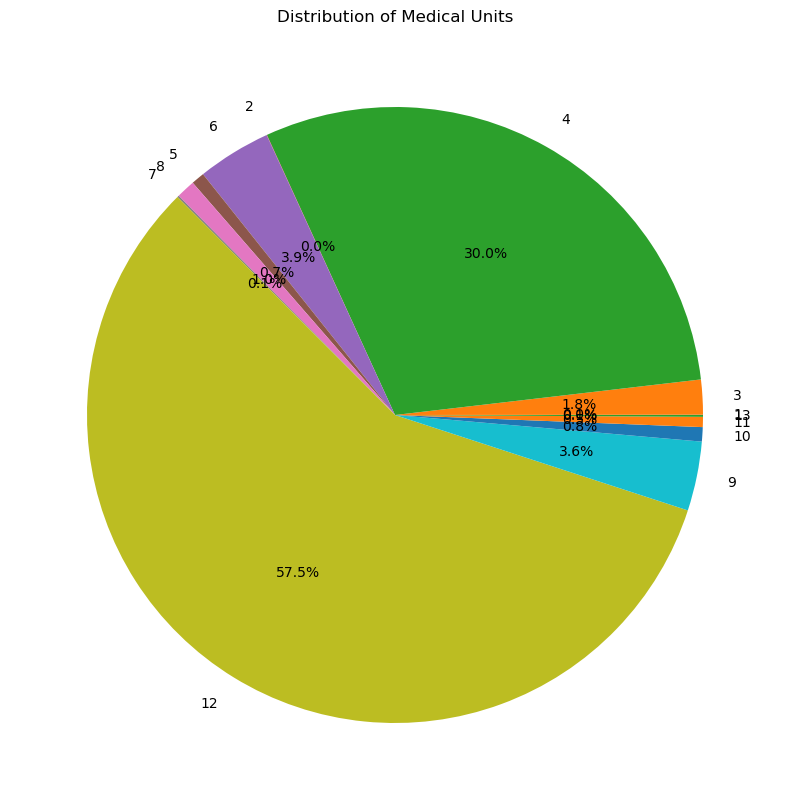

In [ ]:
# Show distribute of MEDICAL_UNIT column in pie chart
import matplotlib.pyplot as plt

medical_units_distribution = spark.sql("SELECT MEDICAL_UNIT, COUNT(*) AS count FROM covid GROUP BY MEDICAL_UNIT").toPandas()

plt.figure(figsize=(15, 10))
plt.pie(medical_units_distribution["count"], labels=medical_units_distribution["MEDICAL_UNIT"], autopct="%1.1f%%")

plt.title("Distribution of Medical Units")
plt.show()

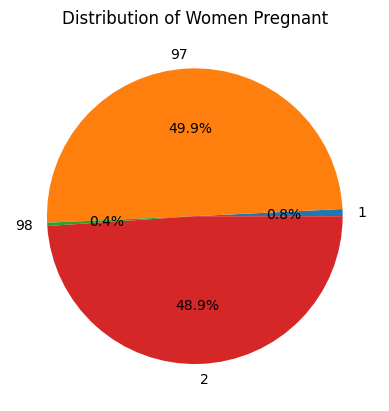

In [ ]:
# Show distribution of 'PREGNANT' column in pie chart
import matplotlib.pyplot as plt

pregnant_distribution = spark.sql("SELECT PREGNANT, COUNT(*) as Count FROM covid GROUP BY PREGNANT").toPandas()

plt.pie(pregnant_distribution["Count"], labels=pregnant_distribution["PREGNANT"], autopct="%1.1f%%")
plt.title("Distribution of Women Pregnant")
plt.show()

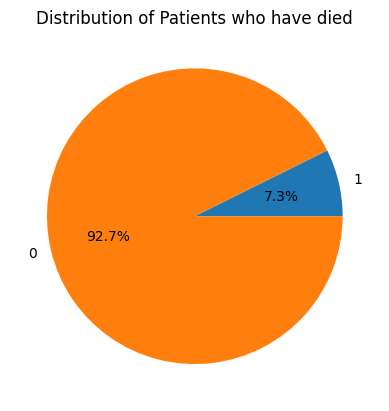

In [ ]:
# Show distribution of 'hasDied' column in pie chart
import matplotlib.pyplot as plt

died_distribution = spark.sql("SELECT hasDied, COUNT(*) as Count FROM covid GROUP BY hasDied").toPandas()

plt.pie(died_distribution["Count"], labels=died_distribution["hasDied"], autopct="%1.1f%%")
plt.title("Distribution of Patients who have died")
plt.show()

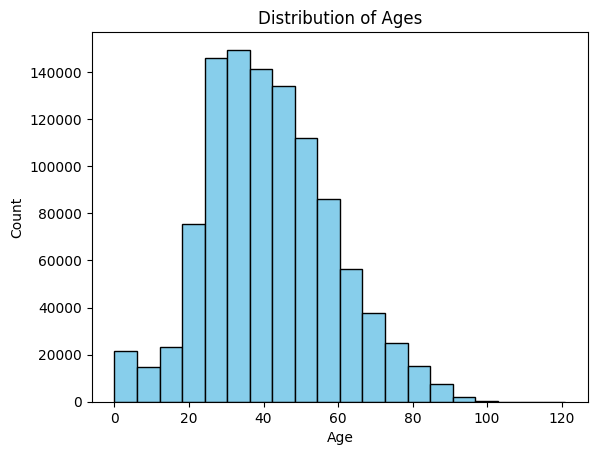

In [ ]:
# Show distribution of 'AGE' column in histogram
import matplotlib.pyplot as plt

age_distribution = spark.sql("SELECT AGE FROM covid").toPandas()

plt.hist(age_distribution["AGE"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

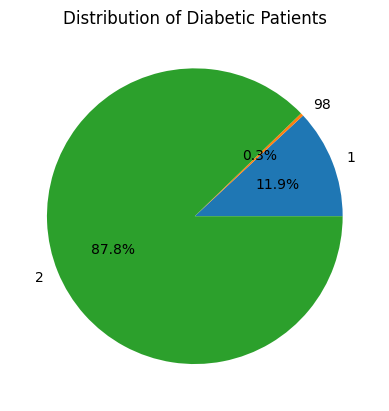

In [ ]:
# Show distribution of 'DIABETES' column in pie chart
import matplotlib.pyplot as plt

diabetes_distribution = spark.sql("SELECT DIABETES, COUNT(*) as Count FROM covid GROUP BY DIABETES").toPandas()

plt.pie(diabetes_distribution["Count"], labels=diabetes_distribution["DIABETES"], autopct="%1.1f%%")
plt.title("Distribution of Diabetic Patients")
plt.show()

In [ ]:
# count, mean, standard deviation, min, and max .
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+-----------------+-------------------+
|summary|             USMER|      MEDICAL_UNIT|                SEX|      PATIENT_TYPE|          INTUBED|         PNEUMONIA|               AGE|         PREGNANT|          DIABETES|              COPD|            ASTHMA|           INMSUPR|      HIPERTENSION|    OTHER_DISEASE|    CARDIOVASCULAR|          OBESITY|     RENAL_CHRONIC|           TOBACCO|CLASIFFICATION_FINAL|              ICU|            hasDied|
+-------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----

In [ ]:
#number of rows
df.count()

1048575

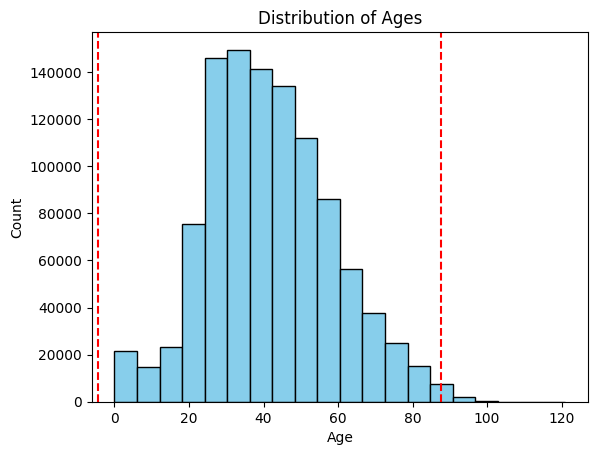

In [ ]:
# Find outliers in the 'AGE' column
from pyspark.sql.functions import col

q1, q3 = df.approxQuantile("AGE", [0.25, 0.75], 0)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Show the outliers in a chart

import matplotlib.pyplot as plt

age_distribution = spark.sql("SELECT AGE FROM covid").toPandas()

plt.hist(age_distribution["AGE"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Ages")
plt.xlabel("Age")
plt.ylabel("Count")

plt.axvline(lower_bound, color="red", linestyle="--")
plt.axvline(upper_bound, color="red", linestyle="--")

plt.show()

In [ ]:
 #number of nulls in the column
from pyspark.sql.functions import col, when, count
null_counts = []
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    null_counts.append((column, null_count))

print('Column/Null Count')
for column, count in null_counts:
    print(f"{column}:{count}")

Column/Null Count
USMER:0
MEDICAL_UNIT:0
SEX:0
PATIENT_TYPE:0
INTUBED:0
PNEUMONIA:0
AGE:0
PREGNANT:0
DIABETES:0
COPD:0
ASTHMA:0
INMSUPR:0
HIPERTENSION:0
OTHER_DISEASE:0
CARDIOVASCULAR:0
OBESITY:0
RENAL_CHRONIC:0
TOBACCO:0
CLASIFFICATION_FINAL:0
ICU:0
hasDied:0


In [ ]:
# range and distribution in each feature to discover imbalances
for col in df.columns:
    df.groupBy(col).count().show()

+-----+------+
|USMER| count|
+-----+------+
|    1|385672|
|    2|662903|
+-----+------+

+------------+------+
|MEDICAL_UNIT| count|
+------------+------+
|          12|602995|
|           1|   151|
|           6| 40584|
|           3| 19175|
|           5|  7244|
|           9| 38116|
|           4|314405|
|           8| 10399|
|           7|   891|
|          10|  7873|
|          11|  5577|
|           2|   169|
|          13|   996|
+------------+------+

+---+------+
|SEX| count|
+---+------+
|  1|525064|
|  2|523511|
+---+------+

+------------+------+
|PATIENT_TYPE| count|
+------------+------+
|           1|848544|
|           2|200031|
+------------+------+

+-------+------+
|INTUBED| count|
+-------+------+
|      1| 33656|
|     97|848544|
|      2|159050|
|     99|  7325|
+-------+------+

+---------+------+
|PNEUMONIA| count|
+---------+------+
|        1|140038|
|        2|892534|
|       99| 16003|
+---------+------+

+---+-----+
|AGE|count|
+---+-----+
| 31|25927|
| 8

In [37]:
# A brief analysis of mortality rate for COVID subjects with Diabetes and/or
# asthma.  Then distributed by age and sex.

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, avg

# Load dataset
df = spark.read.csv("covid_data.csv", header=True, inferSchema=True)

# Define mortality column based on DATE_DIED
df = df.withColumn("MORTALITY", when(col("DATE_DIED") != "9999-99-99", 1).otherwise(0))

# Select relevant columns including AGE
df_selected = df.select("SEX", "ASTHMA", "DIABETES", "AGE", "MORTALITY")

# Group by SEX, ASTHMA, and DIABETES to calculate mortality rate and average age
df_grouped = df_selected.groupBy("SEX", "ASTHMA", "DIABETES") \
    .agg(
        count("MORTALITY").alias("Total"),
        count(when(col("MORTALITY") == 1, "MORTALITY")).alias("Mortality_Count"),
        avg("AGE").alias("Average_Age")  # Calculate average age
    ) \
    .withColumn("Mortality_Rate", col("Mortality_Count") / col("Total"))

# Show results
df_grouped.show()

# Convert to Pandas DataFrame for visualization
df_pandas = df_grouped.toPandas()




+---+------+--------+------+---------------+------------------+--------------------+
|SEX|ASTHMA|DIABETES| Total|Mortality_Count|       Average_Age|      Mortality_Rate|
+---+------+--------+------+---------------+------------------+--------------------+
|  2|     2|       2|446715|          31823| 40.28638169750288| 0.07123781381865395|
|  1|     1|       1|  2666|            356|53.200675168792195| 0.13353338334583645|
|  1|    98|      98|  1082|            196| 48.34473197781885| 0.18114602587800369|
|  2|     2|      98|   392|             90| 51.04081632653061| 0.22959183673469388|
|  1|     1|      98|    20|              2|              43.1|                 0.1|
|  2|     2|       1| 62859|          16459| 57.12421451184397|  0.2618399910911723|
|  1|     2|       2|445748|          15185| 39.27660471836105| 0.03406633344400872|
|  1|     1|       2| 17078|            430| 38.55761798805481| 0.02517859234102354|
|  2|    98|       1|    72|             39|58.958333333333336|  

<ipython-input-39-a2decbc5ccbe>:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles=kde_asthma.legend_.legendHandles + kde_diabetes.legend_.legendHandles,


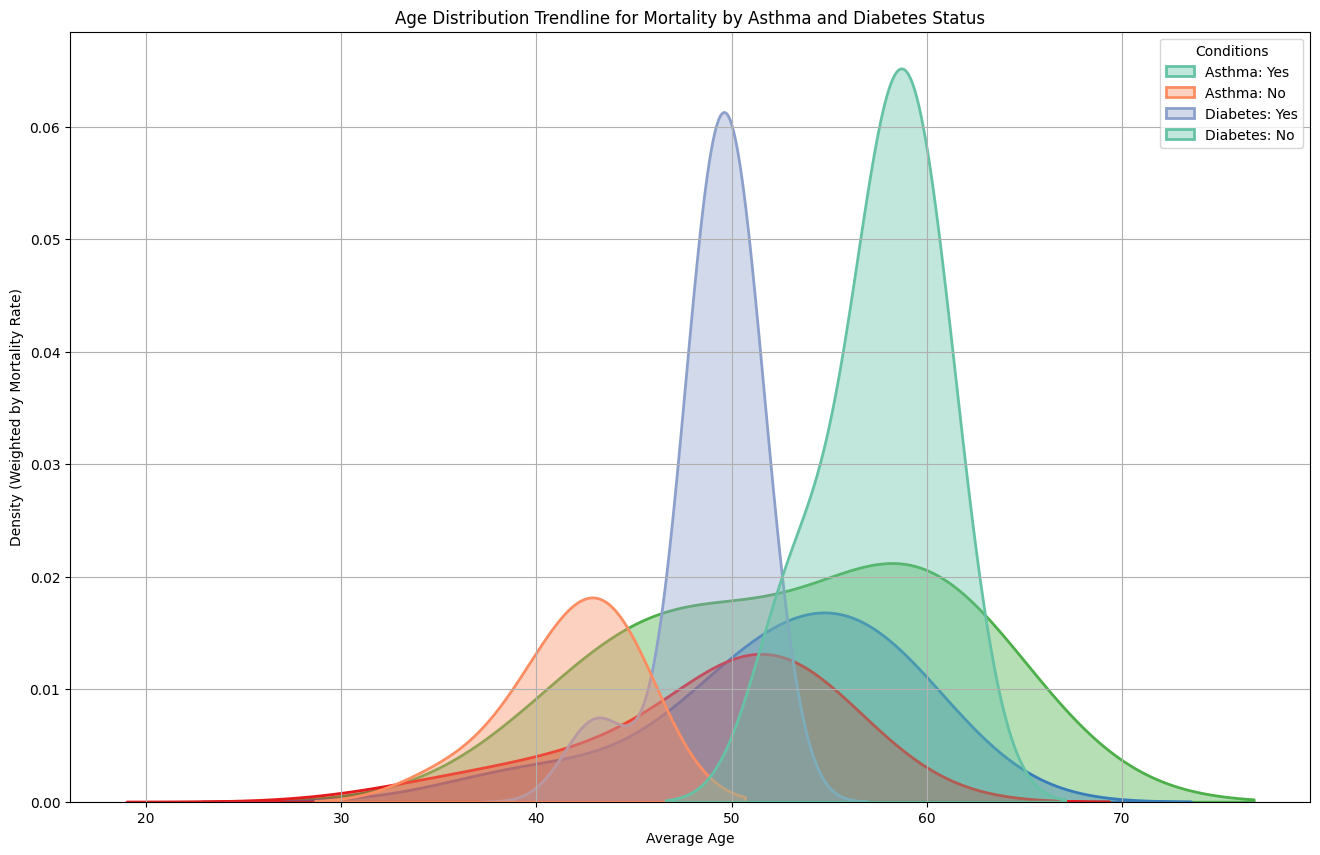

In [39]:
# Visualization shows age trend distribution comparing mortality rates based on
# sex and age for asthma and diabetes.

# Single chart showing age distribution trendline for mortality with conditions
plt.figure(figsize=(16, 10))

# Trendline for ASTHMA and AGE distribution
kde_asthma = sns.kdeplot(
    data=df_pandas,
    x="Average_Age",
    hue="ASTHMA",
    weights="Mortality_Rate",
    palette="Set1",
    linewidth=2,
    fill=True,
    alpha=0.4
)

# Trendline for DIABETES and AGE distribution
kde_diabetes = sns.kdeplot(
    data=df_pandas,
    x="Average_Age",
    hue="DIABETES",
    weights="Mortality_Rate",
    palette="Set2",
    linewidth=2,
    fill=True,
    alpha=0.4
)

# Chart styling
plt.title("Age Distribution Trendline for Mortality by Asthma and Diabetes Status")
plt.xlabel("Average Age")
plt.ylabel("Density (Weighted by Mortality Rate)")

# Adding a custom legend
plt.legend(
    handles=kde_asthma.legend_.legendHandles + kde_diabetes.legend_.legendHandles,
    labels=["Asthma: Yes", "Asthma: No", "Diabetes: Yes", "Diabetes: No"],
    title="Conditions",
    loc="upper right"
)

plt.grid(True)

# Show the combined chart
plt.show()


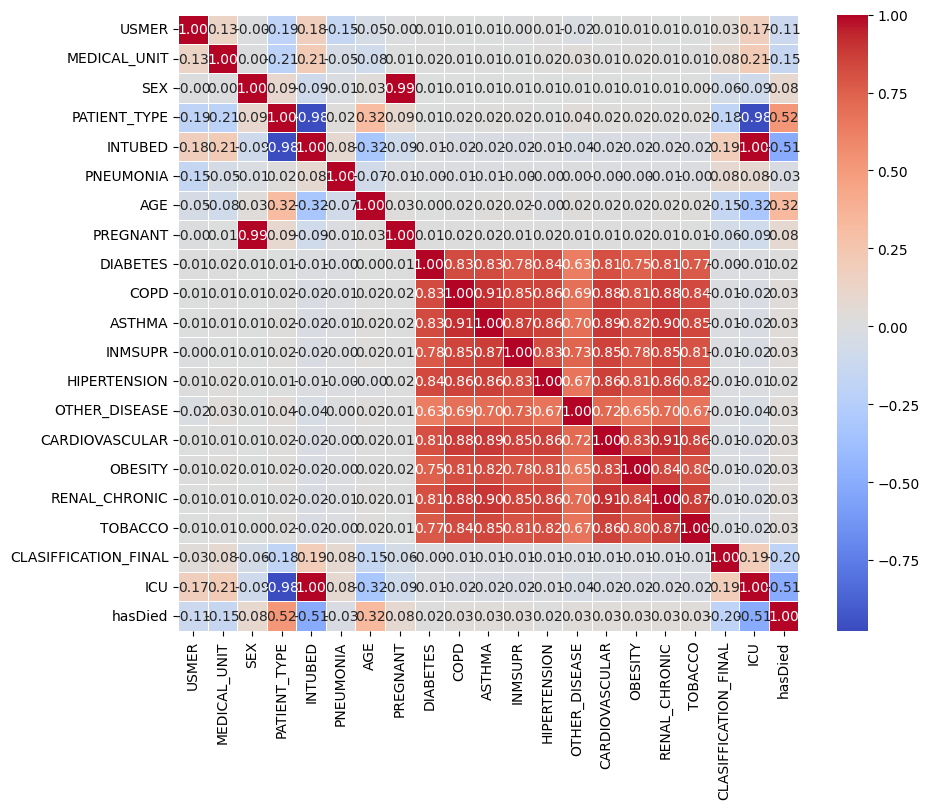

In [ ]:
# correlation matrix helps us see which features are affected by each other and which have an influence on the hasDied
import seaborn as sns
import matplotlib.pyplot as plt
df_pandas = df.toPandas()
df_numerical = df_pandas.select_dtypes(include=['number'])
corrmatrix = df_numerical.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrmatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

#### Notes about Correlation Matrix:
The higher the patient's type then the more likely of the patient is or was in ICU. There is a perfect positive correlation where patients that are Intubed are in ICU. Intubed has the highest positive correlation with hasDied. There is a large box in the middle of the correlation matrix where several of the patients diseases are positively correlated with each other. From this information, we can assume that if a pateint has any of these diseases the are likely to have the others.

#### Conclusion from Data Exploration:
The target column 'hasDied' has a very imbalanced distribution. This discovery means we must consider models that can handle imbalances. Those options could be tree-based models, while Logistic Regression and Support Vector Machines can be used with editing the class weights or resampling.

# Machine Learning Algorithm Preparation and Tuning

## Setting Up a Random Forest Classifier

In [ ]:
# Setup a tree-based model to predict the 'hasDied' column
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

features = [col for col in df.columns if col not in ["hasDied"]]

# Create a vector assembler
# The input columns are all columns except 'hasDied'
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Create a random forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="hasDied")

# Create a pipeline
rf_pipeline = Pipeline(stages=[assembler, rf])

# Split the data into training and testing sets
train, test = df.randomSplit([0.7, 0.3])

# Fit the model
rf_model = rf_pipeline.fit(train)

# Make predictions
rf_predictions = rf_model.transform(test)

## Setting Up a Logistic Regression Model

In [ ]:
# Setup a logistic regression model to predict the 'hasDied' column
from pyspark.ml.classification import LogisticRegression

# Create a logistic regression classifier
lr = LogisticRegression(featuresCol="features", labelCol="hasDied")

# Create a pipeline
lr_pipeline = Pipeline(stages=[assembler, lr])

# Fit the model
lr_model = lr_pipeline.fit(train)

# Make predictions
lr_predictions = lr_model.transform(test)

# Model Evaluation and Visualization

## Random Forest Evaluation and Visuals

In [ ]:
# Show the accuracy of the model with *binary* classification evaluator
# since we are trying to predict if a patient has died or not (binary classification).
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf_evaluator = BinaryClassificationEvaluator(labelCol="hasDied")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)

print(f"Accuracy: {rf_accuracy}")

Accuracy: 0.959614143652809


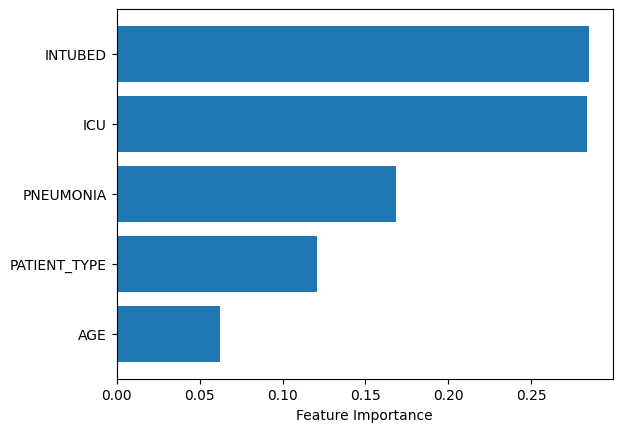

In [ ]:
# Show the top 5 feature importances in a chart
import matplotlib.pyplot as plt

rf_model_stages = rf_model.stages[-1]
rf_feature_importances = rf_model_stages.featureImportances

rf_importances = rf_feature_importances.toArray()
rf_indices = rf_importances.argsort()[-5:]

plt.barh(range(len(rf_indices)), rf_importances[rf_indices])
plt.yticks(range(len(rf_indices)), [features[i] for i in rf_indices])
plt.xlabel("Feature Importance")
plt.show()

In [ ]:
# Cross-validation for Random Forest Classifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 30]).build()

crossval = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=param_grid, evaluator=rf_evaluator, numFolds=3)

cv_model = crossval.fit(train)

cv_predictions = cv_model.transform(test)

cv_accuracy = rf_evaluator.evaluate(cv_predictions)

print(f"Accuracy: {cv_accuracy}")

Accuracy: 0.9557455523083425


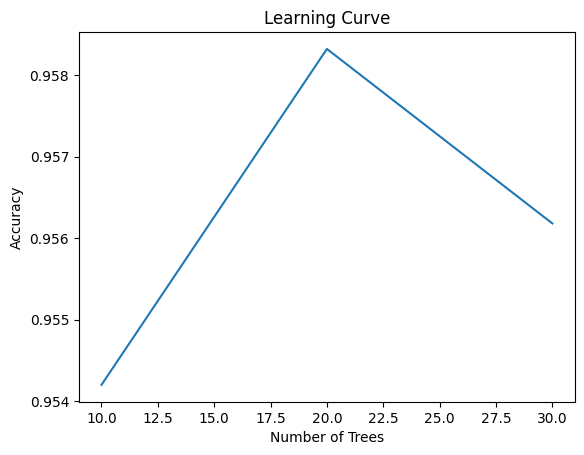

In [ ]:
# Show chart of the learning curve
import matplotlib.pyplot as plt

cv_models = cv_model.avgMetrics

plt.plot([10, 20, 30], cv_models)
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()

### Conclusion on the learning curve

The Random Forest Model had the best accuracy using 20 trees within its algorithm, which is the default number of trees, for predicting whether a patient is at risk of dieing.

## Logistic Regression Model Evaluation and Visuals

In [ ]:
# Evaluate the logistic regression model's accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="hasDied", metricName="accuracy")

# Evaluate the model
lr_accuracy = evaluator.evaluate(lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy}")

Logistic Regression Accuracy: 0.9357229381074559


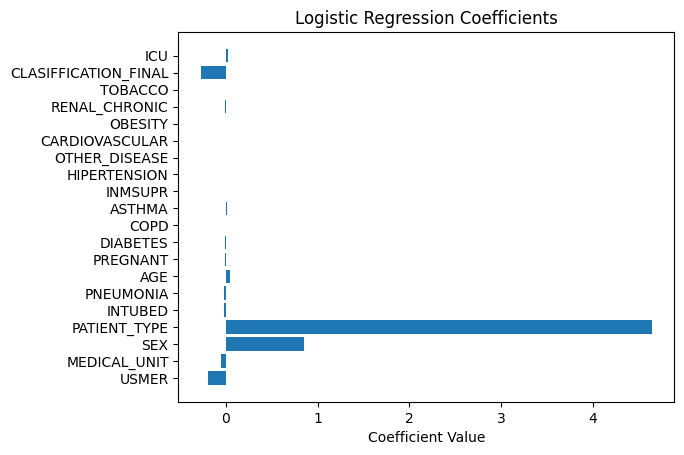

In [ ]:
# Show the coefficients of the logistic regression model
lr_model_stages = lr_model.stages[-1]
lr_coefficients = lr_model_stages.coefficients.toArray()

plt.barh(range(len(lr_coefficients)), lr_coefficients)
plt.yticks(range(len(lr_coefficients)), features)
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Coefficients")
plt.show()

In [ ]:
# Cross-validation for Logistic Regression
param_grid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01, 0.001]).build()

crossval = CrossValidator(estimator=lr_pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

cv_model = crossval.fit(train)

cv_predictions = cv_model.transform(test)

cv_accuracy = evaluator.evaluate(cv_predictions)

print(f"Logistic Regression Accuracy: {cv_accuracy}")

Logistic Regression Accuracy: 0.9352396758327531


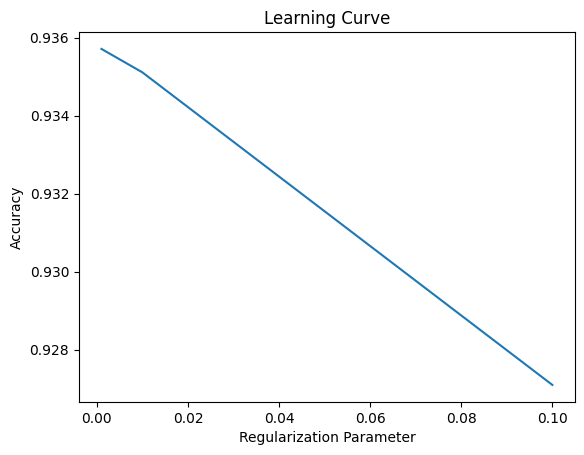

In [ ]:
# Show chart of the learning curve
cv_models = cv_model.avgMetrics

plt.plot([0.1, 0.01, 0.001], cv_models)

plt.xlabel("Regularization Parameter")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()

# Limitations, Future Work, and Conclusion

## Conclusion

(TODO: Talk about which model performed the best and potiently why, if we know.)

In [ ]:
'''
This project showed key insights from the COVID dataset and were derived through feature engineering, data visualization, and model evaluation. Going
from the top of the notebook to the bottom, we can observe that certain features such as ICU admission, intubation status, pneumonia diagnosis, and
patient type were the most critial predictors of mortality. These observations align with the known severity indicators for COVID and shows the how
important it is to monitor high risk factors when it comes to patient care.

When looking at the different models we used, the Random Forest Classifier outpreformed the other models with an accuracy score of 95.96%. We believe
Random Tree did the best because of its ability to handle complex relationships between features. Also Random Tree is good at handling feature
importance which works well with our dataset because some health factors can contribute more to a patients health than others. Logistic
Regression was slightly less accurate with a score of 93.57%, which helped provide a better framework for understanding the impact of individual
features in the model. For each model we used cross validation and did hyperparameter tuning to enhance each models performace, to ensure the
reliability in each models' predictions.

The correlation matrix above gives us valuable insights into feature interrelationships, and shows the strong positive correleation between critical
conditions like intubation and ICU status. This overlap really shows and emphasizes how complex the COVID outcomes are and the need for models that are
capable of handlinng feature interdependencies effectively.

Overall, our project shows the potential of machine learning in supporting healthcare workers and companies' decision making. By looking at high risk
patient data based on their symptoms and medical history, the models could be used to optimize resource allocation and save patient lives. In a real
world setting, we would have to address data and dataset limitations and also constantly expanding our feature set to enhance the accuracy of our models.
'''

## Limitations

In [ ]:
'''
This project had several limitations that should be considered if used in the future. One of the major issues was the imbalance in the "hasDied" column.
This showed that only 7.3% of patients were marked as deceased. This imbalance may have caused the models to favor predicting the majority class, but
with using the Random Forest model, it was able to handle that very well. Secondly, the data set covers COVID cases up to a specific date, which may not
show the later stages during the pandemic when treatments and outcomes improved. Another issue was that some features like intubed and ICU, were highly
related, which may have made it harder for the Logistic Regression model to perform at its full potential and produce accurate results. Also the dataset
left out some potentially important details like vaccination status and the location of paients, which could have helped in providing a better
understanding of the outcomes. The last few limitations came from some of the features like "PATIENT_TYPE" and "MEDICAL_UNIT", being converted into a
numerical value, which may have simplified their interpretation and lost some nuances. Lastly, the dataset did not seem to have some analysis techniques
like, dimensionality reduction or external validation with data that came from different regions. This may have let to some data being skewed for false
entirely.
'''

## Future Work

In [ ]:
'''
One area of work we could do in the future is enriching the dataset with additional features, like vaccination status, location of patient, and more
detailed temporal data. These would provide more context for patient outcomes and help each model capture more long term trends or regional severity of
COVID. Adding more fine details about treatment timelines and resource availability would also help the models predictive power. Another thing we could
do is address the "hasDied" column. Techniques like oversampling the minority class or applying class weight during model training could further improve
accuracy for patients with a higher risk of mortality. Future work could also focus on reducing redundancy and correlation issues, with "intubed" and
"ICU". Dimensionality reduction methods could help simplify the dataset while retaining key information. Lastly, external validation with dataset from
different regions and time periods would really help the models produce more accurate results. This step would ensure that the prediction is taking into
consideration a diverse real world setting. Developing an interactive dashboard to visualize the predictions of the model and show feature importance
would help decision makers in the medical field to make accurate and informed decisions in real time.
'''

In [ ]:
# Close the Spark session

spark.stop()

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")